<a href="https://colab.research.google.com/github/ussozi/Covid_19_predictions/blob/main/Covid19_EDA_and_Uganda_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory and Post Prediction Analysis

In [4]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import packages and Define Functions used

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy
import statsmodels
import sklearn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

#Define Functions
def rmse(y_true, y_pred):
   return np.sqrt(mean_squared_error(y_true, y_pred))

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# create a differenced series
def difference(dataset, interval=1):
	diff = []
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load and Pre process data

In [40]:
#load data
data=pd.read_csv(r'/content/drive/MyDrive/ML data/Covid deaths data/train.csv',parse_dates=['Date'],index_col=['Date'])

#Drop unnecesaru columns
data= data.drop(['Territory X Date', 'cases'],axis=1)

#Sort data
data= data.sort_values(['Territory','Date'])


### Check for Seasonality in data

ADF Statistic: -261.042334
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


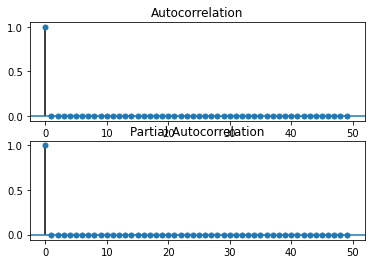

In [3]:
#Checking for seasonality in the data
X = data['target'].values
X = X.astype('float32')

# difference data
days = 1
stationary = difference(X, days)
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

#Plotting tthe ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(stationary, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(stationary, ax=pyplot.gca())
pyplot.show()

### Predicting Uganda's Future Covid deaths and Analysis

In [41]:
##Reset index
data=data.reset_index()

#Picking of Uganda data
raw_data=data[data['Territory']=='Uganda']

In [42]:
#Initializing the model
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(
  interval_width=0.95,
  growth='linear',
  daily_seasonality=True,
  weekly_seasonality=True,
  yearly_seasonality=False,
  changepoint_prior_scale=0.5,
  n_changepoints=200,
  seasonality_mode='multiplicative')

#Getting the data in a format to be consumed by the model
data=raw_data[['Date','target']]

#Changing date to datetime index
data['Date'] = pd.DatetimeIndex(data['Date'])

#force the column names to be ds and y as per prohet requirements
data = data.rename(columns={'Date': 'ds',
                        'target': 'y'})
#fitting model
my_model.fit(data)

#Creating future data frame
future_dates = my_model.make_future_dataframe(periods=106, freq='D')

#predict into the future
forecast = my_model.predict(future_dates)

#Make final dataframe
submission== pd.DataFrame({
    'Territory': 'Uganda',
    'Date':forecast['ds'],
    'target':forecast['yhat'],
    'target_lower':forecast['yhat_lower'],
    'target_upper':forecast['yhat_upper']
})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Uganda Covid deaths line graph

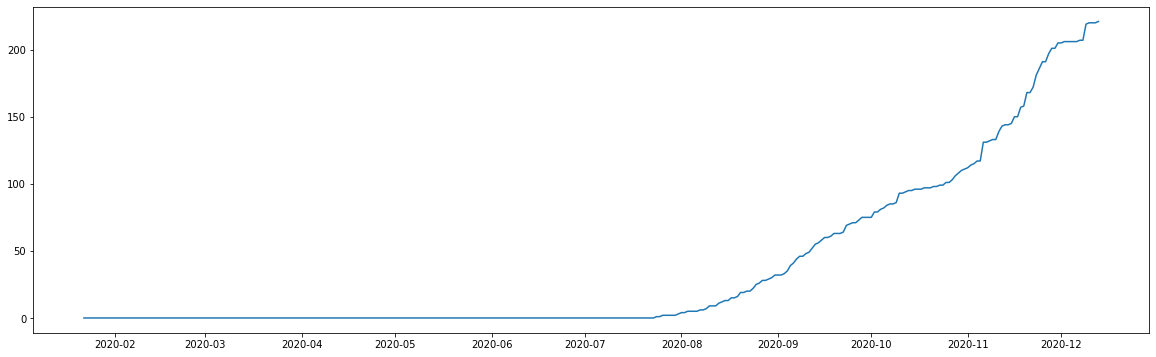

In [44]:
fig = plt.figure(facecolor='w', figsize=(20, 6))
plt.plot(data.ds, data.y)

Plot the actual and forecast values

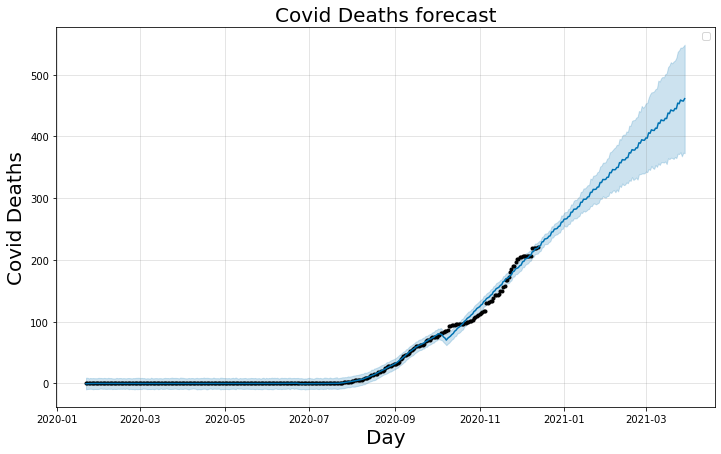

In [49]:
my_model.plot(forecast)
plt.title("Covid Deaths forecast", fontsize=20)
plt.xlabel("Day", fontsize=20)
plt.ylabel("Covid Deaths", fontsize=20)
plt.show()

plot the components

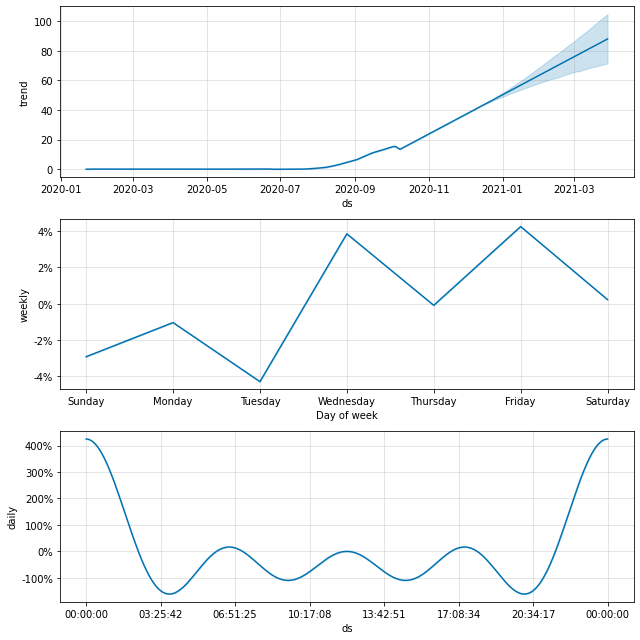

In [50]:
fig2 = my_model.plot_components(forecast)

Computing cross validation and model performance over a period

In [52]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(my_model, horizon='60 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-08-15 00:00:00 and 2020-10-14 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 164.
INFO:fbprophet:n_changepoints greater than number of observations. Using 188.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,56.299458,7.503296,7.114388,0.215701,0.149657,0.055556
1,7 days,58.658750,7.658900,7.397594,0.214073,0.139912,0.000000
2,8 days,64.061421,8.003838,7.839193,0.222499,0.125458,0.000000
3,9 days,77.295626,8.791793,8.561407,0.232185,0.125458,0.000000
4,10 days,96.068496,9.801454,9.476087,0.243321,0.131044,0.000000


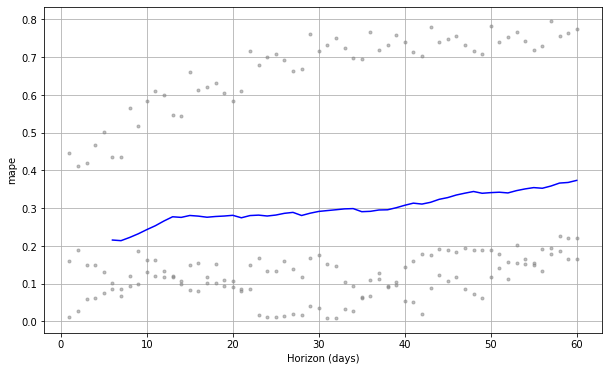

In [53]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')